In [11]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, NMF
from collections import defaultdict
import matplotlib.pyplot as plt

# Load the smaller sample of the dataset
data = pd.read_csv(r"C:\Users\Umesh Bhatt\Downloads\ElectronicsSample.csv", nrows=10000)

# Convert the data into a format suitable for Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['userId', 'productId', 'ratings']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(surprise_data, test_size=0.2)



In [12]:
# Define the models to train
models = {
    'KNNBasic': KNNBasic(),
    'KNNWithMeans': KNNWithMeans(),
    'KNNWithZScore': KNNWithZScore(),
    'KNNBaseline': KNNBaseline(),
    'SVD': SVD(),
    'SVDpp': SVDpp(),
    'NMF': NMF()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = cross_validate(model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Extract the RMSE and MAE results
rmse_results = {name: result['test_rmse'] for name, result in results.items()}
mae_results = {name: result['test_mae'] for name, result in results.items()}



Training KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3765  1.3833  1.3659  1.3928  1.3559  1.3749  0.0129  
MAE (testset)     1.0952  1.1086  1.0878  1.1087  1.0938  1.0988  0.0084  
Fit time          0.24    0.25    0.40    0.27    0.27    0.28    0.06    
Test time         0.01    0.00    0.01    0.00    0.02    0.01    0.01    
Training KNNWithMeans...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing

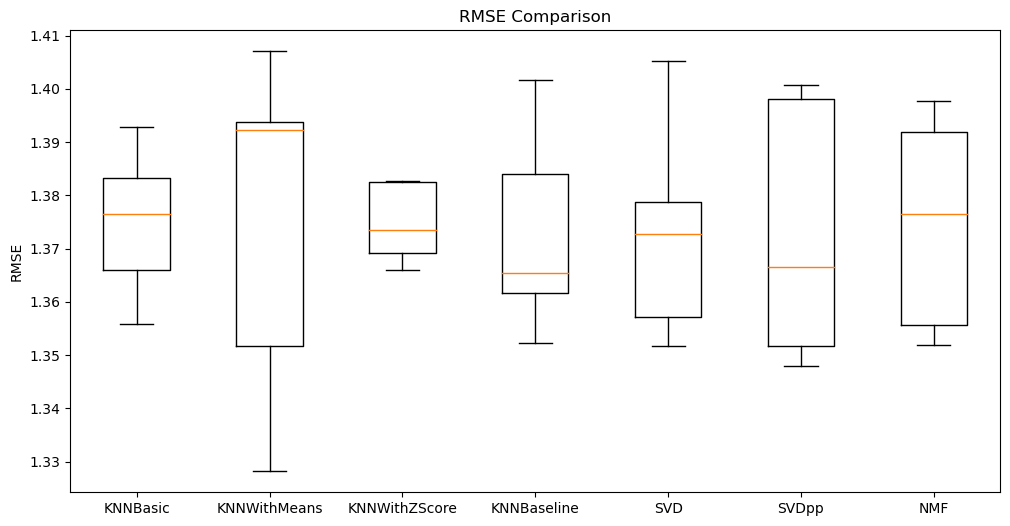

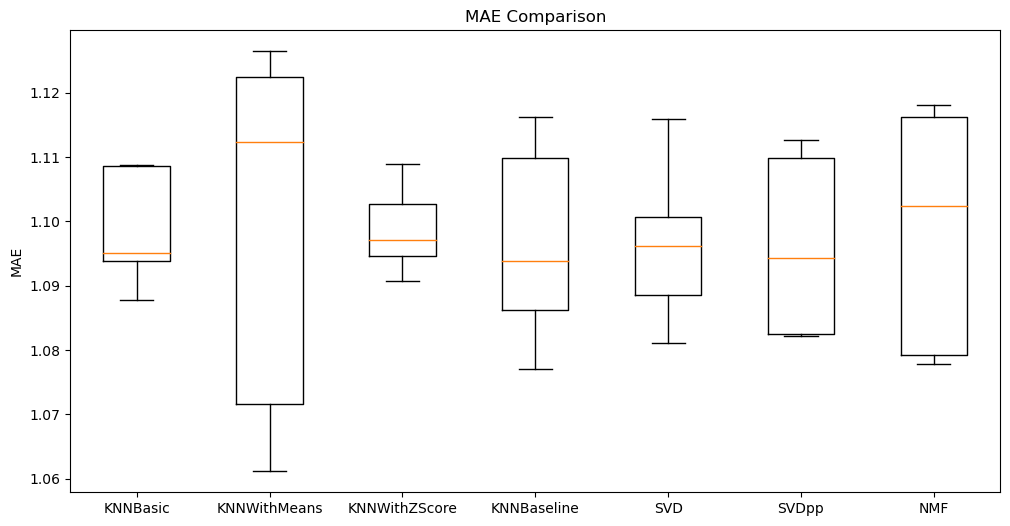

In [13]:
# Plot the RMSE results
plt.figure(figsize=(12, 6))
plt.boxplot(rmse_results.values(), labels=rmse_results.keys())
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

# Plot the MAE results
plt.figure(figsize=(12, 6))
plt.boxplot(mae_results.values(), labels=mae_results.keys())
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.show()



Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating KNNWithMeans...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating KNNWithZScore...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithZScore -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating KNNBaseline...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBaseline -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating SVD...
SVD -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating SVDpp...
SVDpp -> Precision@10: 0.7608, Recall@10: 1.0000
Evaluating NMF...
NMF -> Precision@10: 0.7608, Recall@10: 1.0000


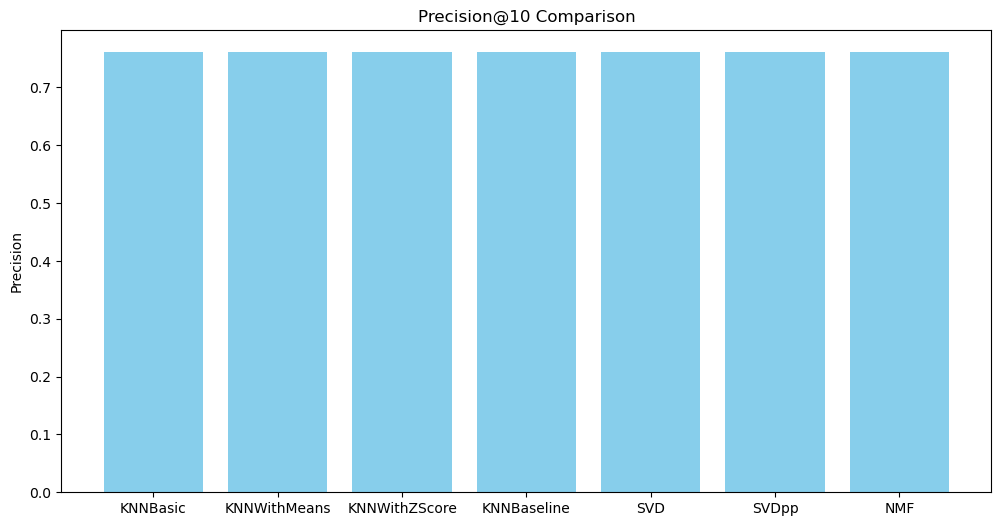

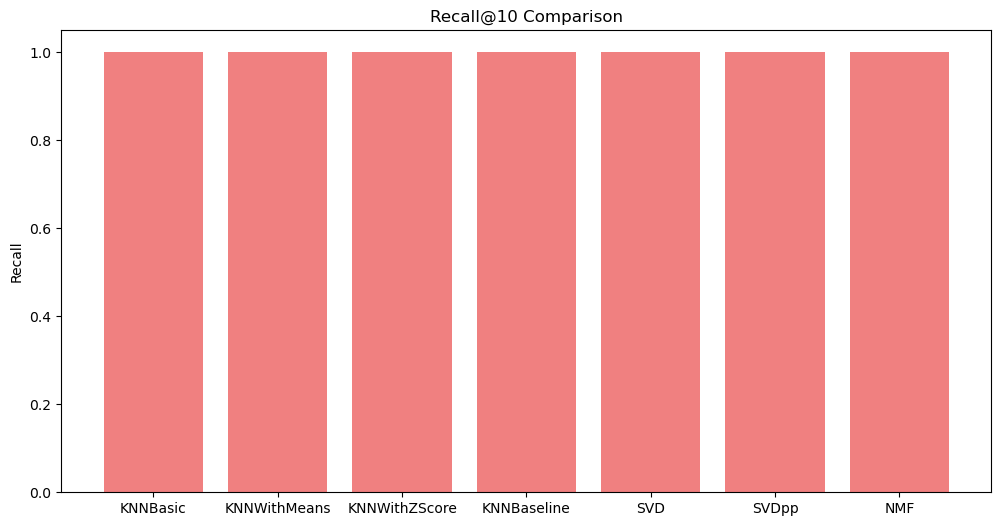

In [14]:
# Evaluate each model with Precision@K and Recall@K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
    recall_avg = sum(rec for rec in recalls.values()) / len(recalls)
    return precision_avg, recall_avg

k = 10
threshold = 3.5
precision_recall_results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    model.fit(trainset)
    predictions = model.test(testset)
    precision, recall = precision_recall_at_k(predictions, k=k, threshold=threshold)
    precision_recall_results[name] = (precision, recall)
    print(f'{name} -> Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}')

# Plot the Precision results
precision_values = [result[0] for result in precision_recall_results.values()]
recall_values = [result[1] for result in precision_recall_results.values()]

plt.figure(figsize=(12, 6))
plt.bar(precision_recall_results.keys(), precision_values, color='skyblue')
plt.title(f'Precision@{k} Comparison')
plt.ylabel('Precision')
plt.show()

# Plot the Recall results
plt.figure(figsize=(12, 6))
plt.bar(precision_recall_results.keys(), recall_values, color='lightcoral')
plt.title(f'Recall@{k} Comparison')
plt.ylabel('Recall')
plt.show()
